In [1]:
import numpy as np
from ipywidgets import interact
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import push_notebook

In [2]:
output_notebook()


Loading BokehJS ...

###### Algorithm

In [3]:
def local_regression(x0, X, Y, tau):
    
    #add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]
    
    
    #fit model : normal equations with Kernel
    xw = X.T * radial_kernel(x0, X, tau)
    beta = np.linalg.pinv(xw @ X) @ xw @ Y    # @ is equivalent to matrix multiplication a.dot(b) or a @ b
                                              # pinv is psuedoinverse, when matrix is not invertible  
    
    #predict value
    return x0 @ beta

Normal Equation of Lowess
https://pm429015.wordpress.com/2013/05/08/linear-regression-2-locally-weighted-linear-regression/

###### https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
Using Singular Value Decomposition, Check for Hermitian Matrix    



In [4]:
def radial_kernel(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis = 1) / (-2 * tau * tau))


###### Data

In [5]:
n = 1000

#generate dataset

X = np.linspace(-3, 3, num = n)
Y = np.log(np.abs(X ** 2 - 1) + 0.5)

#jitter X
X +=np.random.normal(scale = 0.1, size = n)

In [6]:
import matplotlib.pyplot as plt

plt.plot(X, Y)

###### Fit and Plot models

In [7]:
def plot_lwr(tau) :
    
    #predictions
    domain = np.linspace(-3, 3, num=300 )
    prediction = [local_regression(x0, X, Y, tau) for x0 in domain]
    
    plot = figure(plot_width = 400, plot_height =400)
    plot.title.text = 'tau=%g' % tau
    plot.scatter(X, Y, alpha=0.3)
    plot.line(domain, prediction, line_width=2, color ='red')
    
    return plot


In [8]:
show(gridplot([
    [plot_lwr(10.), plot_lwr(1.)], 
    [plot_lwr(0.1), plot_lwr(0.01)]
]))

###### Interactive Plot

In [9]:
def interactive_update(tau):
    model.data_source.data['y'] = [local_regression(x0, X, Y, tau) for x0 in domain]
    push_notebook()
    
domain = np.linspace(-3, 3, num=100)
prediction = [local_regression(x0, X, Y, 1.) for x0 in domain]

plot = figure()
plot.scatter(X, Y, alpha= 0.3)
model = plot.line(domain, prediction, line_width = 2, color ='red')
show(plot, notebook_handle = True)

In [10]:
interact(interactive_update, tau = (0.01, 3., 0.01))

interactive(children=(FloatSlider(value=1.5, description='tau', max=3.0, min=0.01, step=0.01), Output()), _dom…

<function __main__.interactive_update(tau)>

###### For more basic implementation of one variable and Explanation
https://xavierbourretsicotte.github.io/loess.html

###### Implementation of above Resource

###### Using Bell shaped Kernel

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from Ipython.display import Image
from Ipython.display import display
plt.style.use('seaborn-white')
%matplotlib inline


ModuleNotFoundError: No module named 'Ipython'

In [17]:
conda install -c anaconda ipython 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\NF_HR\Anaconda3

  added / updated specs:
    - ipython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         3.0 MB  anaconda
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> anaconda::conda-4.8.3-py37_0




conda-4.8.3          | 3.0 MB    |            |   0% 
conda-4.8.3          | 3.0 MB    |            |   1% 
conda-4.8.3          | 3.0 MB    | 8          |   8% 
conda-4.8.3          | 3.0 MB    | ##8        |  29% 
conda-4.8.3          | 3.0 MB    | #####9     |  60% 
conda-4.8.3          | 3.0 MB    | ########## | 100% 
Prep

In [50]:
#defining bell shaped kernel function  - used for plotting later
def kernel_function(xi, x0, tau =0.005):
    return np.exp( - (xi - x0) ** 2/ (2 * tau)  )


def lowess_bell_shape_kern(x, y, tau = 0.005):
    m = len(x)
    yest = np.zeros(m)
    
    #initialising all weights from bell shaped kernel function
    w = np.array([np.exp( - (x - x[i]) ** 2/ (2 * tau)  )  for i in range(m)])
    
    #Looping through all X's points
    for i in range(m):
        weights = w[:, i]
        b = np.array([np.sum(weights * y) , np.sum(weights * y * x)]) #check the above documentation for explaination
        A = np.array([[np.sum(weights) , np.sum(weights * x)] ,
                     [np.sum(weights * x) , np.sum(weights * x * x)]] )
        
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i]
        
        
    return yest
        

###### Implementing using Span Kernel and robustifying iterations
Chcek Xavier bourrett as above and sample calculations in http://voteforamerica.net/Docs/Local%20Regression.pdf

In [51]:
def lowess_ag(x, y, f= 2./3., iter = 3):
    '''
    Lowess smoother : Robust locally weighted regression
    '''
    
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1- w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [52]:
f = 0.25
yest = lowess_ag(x, y, f=f, iter = 3)
yest_bell = lowess_bell_shape_kern(x, y)

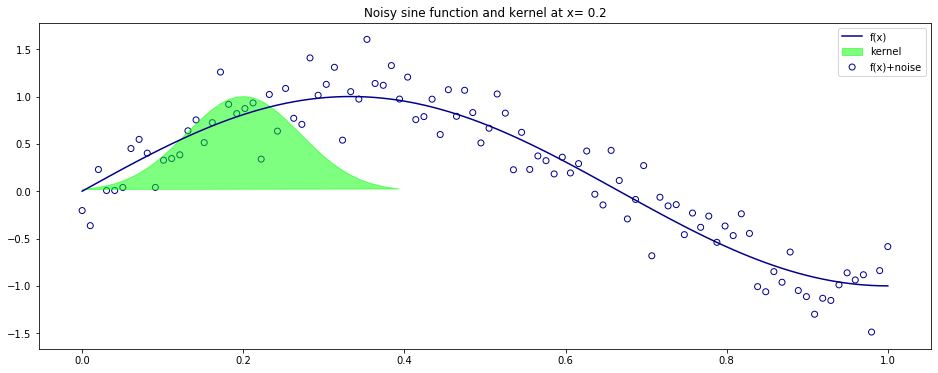

In [53]:
#Initialising non linear data
x = np.linspace(0, 1, 100)
noise = np.random.normal(loc = 0, scale= 0.25, size = 100)
y = np.sin(x * 1.5 * np.pi)
y_noise = y + noise

#Plotting the data and kernel around x=0.2
plt.figure(figsize=(16,6))
plt.plot(x, y, color = 'darkblue', label ='f(x)')
plt.scatter(x, y_noise, facecolors = 'none', edgecolors = 'darkblue', label ='f(x)+noise')
plt.fill(x[:40], kernel_function(x[:40], 0.2, 0.005), color = 'lime', alpha = 0.5, label = 'kernel')
plt.legend()
plt.title('Noisy sine function and kernel at x= 0.2')
plt.show()

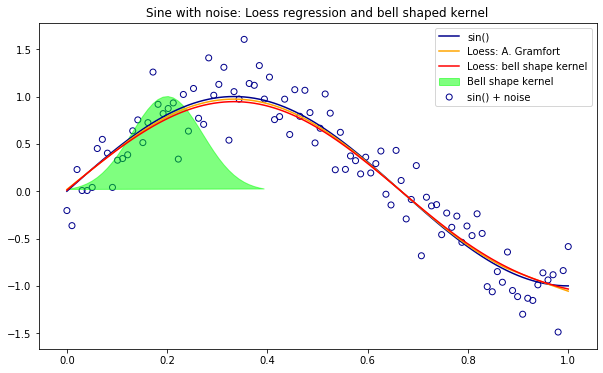

In [54]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()')
plt.scatter(x, y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40], kernel_function(x[:40],0.2,.005), color = 'lime', alpha = .5, label = 'Bell shape kernel')
plt.plot(x, yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x, yest_bell,color = 'red', label = 'Loess: bell shape kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and bell shaped kernel')
plt.show()



###### Alternative Implementation using StatsModel


In [56]:
import statsmodels.api as sm
lowess_sm = sm.nonparametric.lowess
yest_sm = lowess_sm(y, x, frac = 1./3., it = 3, return_sorted = False)

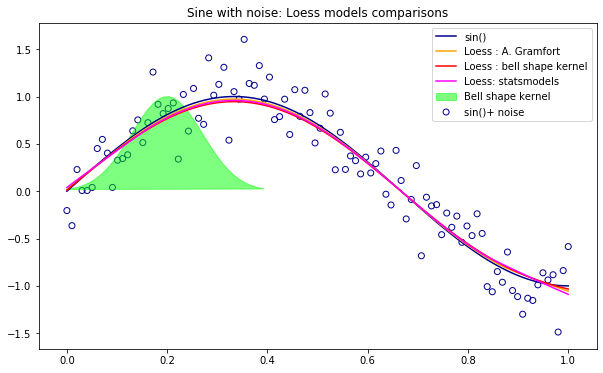

In [58]:
plt.figure(figsize = (10,6))
plt.plot(x, y, color = 'darkblue', label = 'sin()')
plt.scatter(x, y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin()+ noise')
plt.fill(x[:40], kernel_function(x[:40], 0.2, 0.005), color = 'lime', alpha = 0.5, label = 'Bell shape kernel')
plt.plot(x, yest, color = 'orange', label = 'Loess : A. Gramfort')
plt.plot(x, yest_bell, color = 'red', label = 'Loess : bell shape kernel')
plt.plot(x, yest_sm, color = 'magenta', label = 'Loess: statsmodels')
plt.legend()
plt.title('Sine with noise: Loess models comparisons')
plt.show()



# New implementation of Locally weighted regression

###### Source
https://github.com/geeksnome/machine-learning-made-easy/blob/master/locally_weighted_regression.py

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
from sklearn.datasets import load_boston

In [64]:
boston = load_boston()

In [66]:
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data['target'] = boston['target']

In [71]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
target     506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


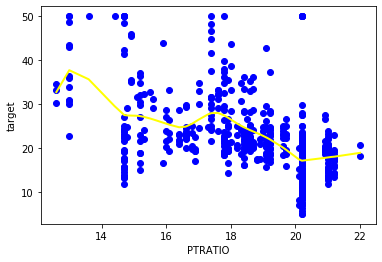

In [96]:
#Gaussian Kernel
def kernel(point, xmat, k):
    m ,n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    
    for i in range(m):
        diff = point - X[i]
        weights[i, i] =  np.exp( (diff * diff.T)/ (-2.0 * k**2))
    
    
    return weights



def localweight(point, xmat, ymat, k):
    wt = kernel(point, xmat, k)
    W = (X.T* (wt*X)).I * (X.T * wt * ymat.T)
    return W



def localweightRegression(xmat, ymat, k):
    m, n = np.shape(xmat)
    ypred = np.zeros(m)
    
    for i in range(m):
        ypred[i] = xmat[i] * localweight(xmat[i], xmat, ymat, k)
        
    return ypred


#column series into numpy arrays
colA = np.array(data['PTRATIO'])
colB = np.array(data['target'])

#numpy arrays into numpy matrices
mcolA = np.mat(colA)
mcolB = np.mat(colB)

#getting number of features
m = np.shape(mcolB)[1]

#Initialising ones matrixes
one = np.ones((1, m), dtype = int)

#horizontal stacking
X = np.hstack((one.T, mcolA.T))

ypred =  localweightRegression(X, mcolB, 0.5)


xsort = X.copy()
xsort.sort(axis=0)
plt.scatter(colA, colB, color = 'blue')
plt.plot(xsort[:,1], ypred[X[:,1].argsort(0)], color = 'yellow', linewidth = 2)
plt.xlabel('PTRATIO')
plt.ylabel('target')
plt.show()

In [84]:
data.corr().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


###### Other useful Resources and Links
https://www.youtube.com/watch?v=0PQKHlwh49A

###### https://github.com/geeksnome/machine-learning-made-easy/blob/master/locally_weighted_regression.py

###### Problems faced
1. For family of symmetric: Different kernels like M-estimation procedure by Tukey's biweight
2. Tricubic weighting proportional
3. Span
4. Kernel Smoothening
5. Search on Drawbacks of Loess
6. Hyper parameter tuning of k ,soan, or number of points in neighbourhood of single point
7. Span as a function of point( treating outliers, and solely standing points)
8. Smoothening as per Y value, rather than just X 
9. Similarity with Generative Additive Models(GAMs)
10. Multifeatures and different shaped polynomials